In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
os.environ["KERAS_BACKEND"] = "jax" 


import keras
from keras import layers
from keras import ops
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
def change_paths(df, data_directory):
    df = df.copy()


    df["ImagePath"] = df["ImagePath"].apply(lambda x: x.replace("/home/data_shares/purrlab_students/padchest-preprocessed/", data_directory))

    return df


In [45]:
image_size = 224  # resize input images to this size
patch_size = 16  # Size of the patches to be extracted from the input images
input_shape = (image_size, image_size, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 50
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
num_patches = (image_size // patch_size) ** 2



# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]  # Size of the dense layers



def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


@keras.saving.register_keras_serializable(name=None)
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config
    
@keras.saving.register_keras_serializable(name=None)
class PatchEncoder(layers.Layer):
    def __init__(self,input_shape, patch_size, num_patches, projection_dim, num_heads, transformer_units, transformer_layers, mlp_head_units,**kwargs):
        super().__init__(**kwargs)

        self.input_shape = input_shape
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = layers.Dense(units=projection_dim)

        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

        self.num_heads = num_heads
        self.transformer_units = transformer_units
        self.transformer_layers = transformer_layers
        self.mlp_head_units = mlp_head_units

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": self.input_shape,
                "patch_size": self.patch_size,
                "num_patches": self.num_patches,
                "projection_dim": self.projection_dim,
                "num_heads": self.num_heads,
                "transformer_units": self.transformer_units,
                "transformer_layers": self.transformer_layers,
                "mlp_head_units": self.mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded
    

In [43]:
data_dir = "/dtu/p1/johlau/LabelReliability_and_PathologyDetection_in_ChestXrays/Data/"
output_dir = "/dtu/p1/johlau/LabelReliability_and_PathologyDetection_in_ChestXrays/ObjectDetection/models/"


pathology_detection_train = pd.read_csv(data_dir + 'Data_splits/pathology_detection-train.csv', index_col=0)
tube_detection_train = pd.read_csv(data_dir + "Data_splits/tube_detection-finetuning.csv", index_col=0)


pathology_detection_val = pd.read_csv(data_dir + 'Data_splits/pathology_detection-val.csv', index_col=0)
tube_detection_val = pd.read_csv(data_dir + "Data_splits/tube_detection-finetuning_val.csv", index_col=0)


pathology_detection_test = pd.read_csv(data_dir + 'Data_splits/pathology_detection-test.csv', index_col=0)


tube_detection_test = pd.read_csv("/dtu/p1/johlau/LabelReliability_and_PathologyDetection_in_ChestXrays/" + "Annotation/Annotations_aggregated.csv", index_col=0)
tube_detection_test = tube_detection_test.rename({"Chest_drain":"Chest_drain_tube"},axis=1)
tube_detection_test["ImagePath"] = tube_detection_test["ImagePath"].apply(lambda x: x.replace("../../", data_dir))
tube_detection_test = tube_detection_test.replace({-1:0})



train_df = pd.concat([pathology_detection_train, tube_detection_train])
val_df = pd.concat([pathology_detection_val, tube_detection_val])
test_df = pd.concat([pathology_detection_test, tube_detection_test])



# Concatenating the datasets for fine-tuning and shuffling
train_df = pd.concat([pathology_detection_train])
train_df_sampled = train_df.sample(n=100, random_state=321).reset_index(drop=True)



# Changing the image paths, so they fit to res24
train_noaug_df = change_paths(train_df_sampled, data_dir + "padchest-preprocessed/")
train_aug_df = change_paths(train_df_sampled, data_dir + "padchest-cropped/")

# Load data into CPU memory
x_train = np.array([keras.utils.img_to_array(keras.utils.load_img(i)) for i in tqdm(train_noaug_df["ImagePath"])])
x_train_aug = np.array([keras.utils.img_to_array(keras.utils.load_img(i)) for i in tqdm(train_aug_df["ImagePath"])])

100%|██████████| 100/100 [00:01<00:00, 95.41it/s]


In [5]:
train_aug_df.iloc[0]["ImagePath"]

'/dtu/p1/johlau/LabelReliability_and_PathologyDetection_in_ChestXrays/Data/padchest-cropped/20/216840111366964013451228379692012249143420078_01-052-108.png'

Image size: 224 X 224
Patch size: 16 X 16
1024 patches per image 
768 elements per patch


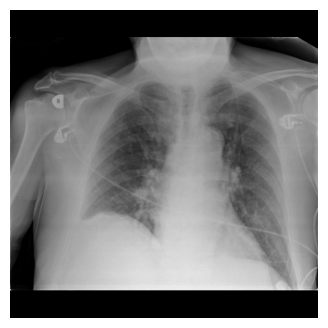

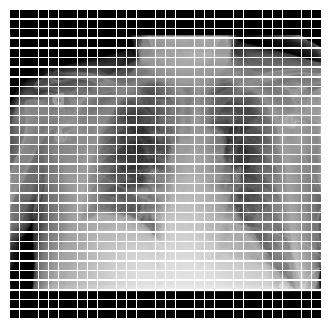

In [46]:
plt.figure(figsize=(4, 4))
plt.imshow(x_train[1].astype("uint8"))
plt.axis("off")

patches = Patches(patch_size)(np.expand_dims(x_train[1], axis=0))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

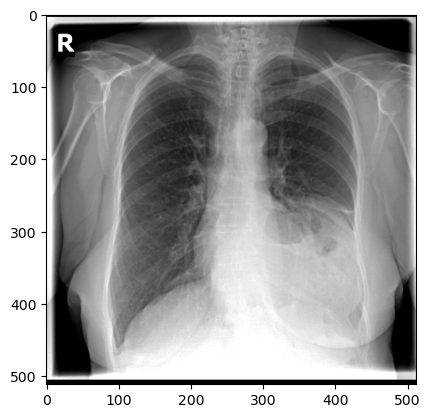

In [42]:
plt.imshow(x_train[0])

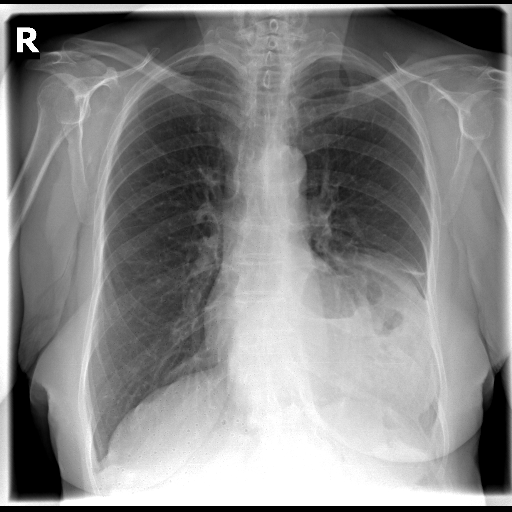

In [41]:
keras.utils.array_to_img(x_train[0])

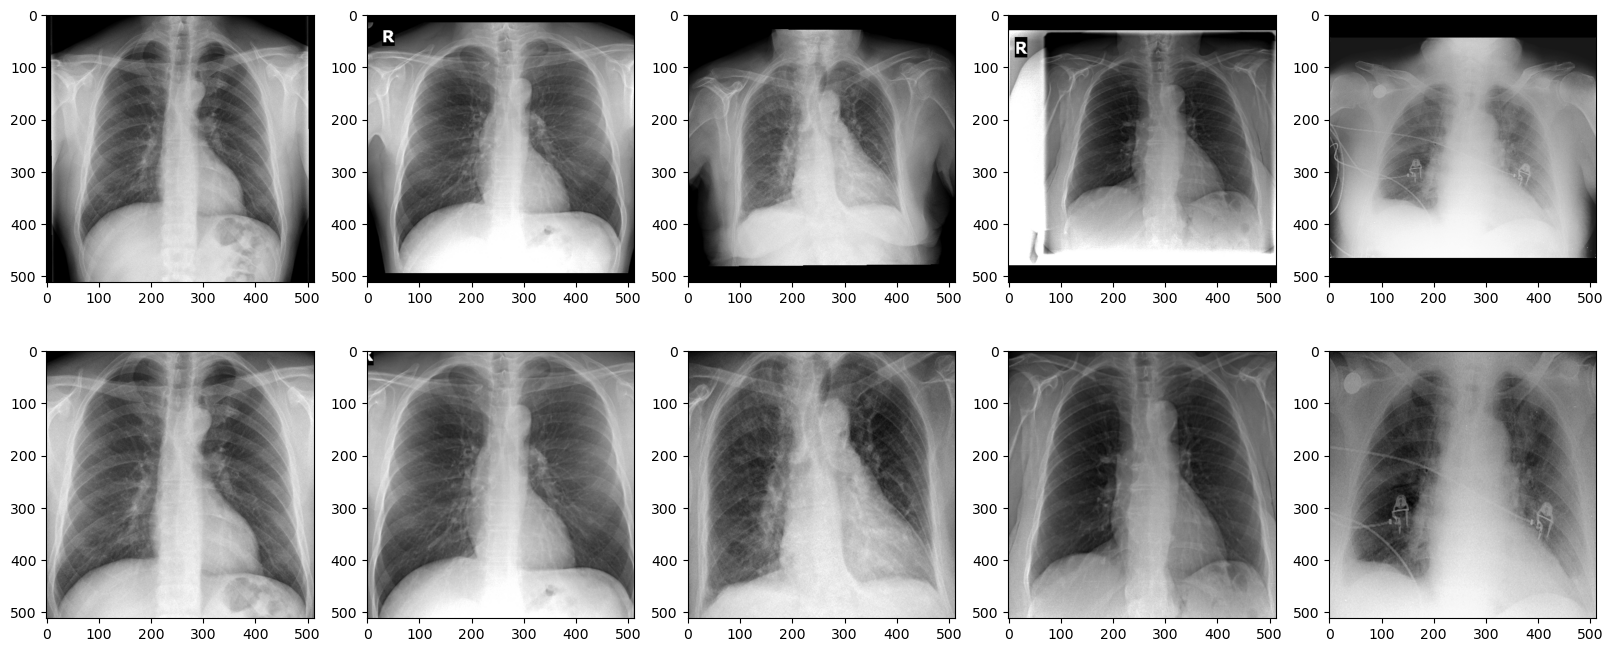

In [37]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))


index_adder = 10


for i in range(0,5):
    axs[0][i].imshow(x_train[i+index_adder])
  #  axs[i].legend(labels=["pd_train_auc","pd_val_auc","td_train_auc","td_val_auc"])
    
for i in range(0,5):
    axs[1][i].imshow(x_train_aug[i+index_adder])
plt.show()

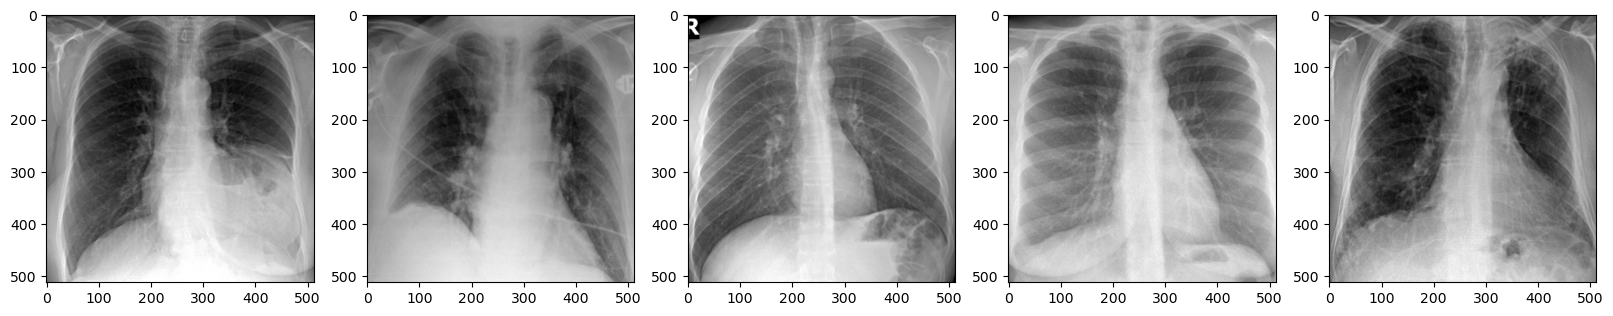

In [9]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

for i in range(5):
    axs[i].imshow(x_train_aug[i])
  #  axs[i].legend(labels=["pd_train_auc","pd_val_auc","td_train_auc","td_val_auc"])
plt.show()

In [10]:
pd_labels = ['Effusion', 'Pneumothorax', 'Atelectasis', 'Cardiomegaly', 'Pneumonia']
td_labels = ['Chest_drain_tube', 'NSG_tube', 'Endotracheal_tube', 'Tracheostomy_tube']

In [11]:
print(train_df[pd_labels].sum())

train_df[pd_labels].value_counts()[0][0][0][0][0]

Effusion        3249
Pneumothorax     163
Atelectasis      958
Cardiomegaly    7248
Pneumonia       3307
dtype: int64


63751

In [12]:
63751/(sum(train_df[pd_labels].sum()) +train_df[pd_labels].value_counts()[0][0][0][0][0])

0.8102979307539784

In [13]:
163/(sum(train_df[pd_labels].sum()) +train_df[pd_labels].value_counts()[0][0][0][0][0])

0.002071788092938126

In [14]:
for i in train_df[pd_labels].sum():
    print((i/(sum(train_df[pd_labels].sum()) +train_df[pd_labels].value_counts()[0][0][0][0][0]))*100)

4.129594793838019
0.2071788092938126
1.2176521429660887
9.212466317555544
4.2033148609487005


In [15]:
print(val_df[pd_labels].sum())

val_df[pd_labels].value_counts()[0][0][0][0][0]

Effusion        750
Pneumothorax     57
Atelectasis     258
Cardiomegaly    960
Pneumonia       483
dtype: int64


9017

In [16]:
for i in val_df[pd_labels].sum():
    print((i/(sum(val_df[pd_labels].sum()) +val_df[pd_labels].value_counts()[0][0][0][0][0]))*100)

6.507592190889371
0.4945770065075922
2.2386117136659434
8.329718004338394
4.190889370932755


In [17]:
(9017/(sum(val_df[pd_labels].sum()) +val_df[pd_labels].value_counts()[0][0][0][0][0]))*100

78.23861171366595

In [18]:
print(test_df[pd_labels].sum())

test_df[pd_labels].value_counts()[0][0][0][0][0]

Effusion        401.0
Pneumothorax     14.0
Atelectasis     126.0
Cardiomegaly    899.0
Pneumonia       376.0
dtype: float64


8205

In [19]:
for i in test_df[pd_labels].sum():
    print((i/(sum(test_df[pd_labels].sum()) +test_df[pd_labels].value_counts()[0][0][0][0][0]))*100)

4.001596647041214
0.13970661610617702
1.2573595449555932
8.971160562818083
3.7521205468516117


In [20]:
(8205/(sum(test_df[pd_labels].sum()) +test_df[pd_labels].value_counts()[0][0][0][0][0]))*100

81.87805608222732

In [21]:
3307+483+376

4166

In [30]:
tube_detection_train

,ImageID,ImagePath,Labels,Effusion,Pneumothorax,Atelectasis,Cardiomegaly,Pneumonia,Chest_drain_tube,NSG_tube,Endotracheal_tube,Tracheostomy_tube
0,216840111366964012373310883942009155091533260_...,/home/data_shares/purrlab_students/padchest-pr...,"['central venous catheter via jugular vein', '...",0,0,1,0,0,0,1,0,0
1,216840111366964012989926673512011062122537402_...,/home/data_shares/purrlab_students/padchest-pr...,['nsg tube'],0,0,0,0,0,0,1,0,0
2,216840111366964012373310883942009160084831219_...,/home/data_shares/purrlab_students/padchest-pr...,"['central venous catheter via jugular vein', '...",0,0,0,0,0,0,1,0,0
3,216840111366964014008416513202014154084018368_...,/home/data_shares/purrlab_students/padchest-pr...,['nsg tube'],0,0,0,0,0,0,1,0,0
4,216840111366964012373310883942009190123832731_...,/home/data_shares/purrlab_students/padchest-pr...,['nsg tube'],0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2112,216840111366964013590140476722013024090612764_...,/home/data_shares/purrlab_students/padchest-pr...,"['pleural effusion', 'nsg tube', 'central veno...",1,0,0,0,1,0,1,0,0
2113,216840111366964012373310883942009187090700305_...,/home/data_shares/purrlab_students/padchest-pr...,"['endotracheal tube', 'nsg tube', 'central ven...",0,0,0,0,0,0,1,1,0
2114,216840111366964013686042548532013192090645560_...,/home/data_shares/purrlab_students/padchest-pr...,"['nsg tube', 'tracheostomy tube']",0,0,0,0,0,0,1,0,1
2115,115618656143164998074474809183697927251_v98b58...,/home/data_shares/purrlab_students/padchest-pr...,"['nsg tube', 'surgery neck', 'tracheostomy tub...",0,0,1,0,0,0,1,0,1


In [22]:
tube_detection_test

,ImageID,ImageDir,ImagePath,Chest_drain_tube,NSG_tube,Endotracheal_tube,Tracheostomy_tube
0,216840111366964012339356563862009041090824095_...,47,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0,0,0,1
1,216840111366964013686042548532013298085500915_...,13,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0,0,0,0
2,216840111366964013076187734852011188142138830_...,39,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0,1,0,0
3,216840111366964013451228379692012296085047250_...,30,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0,0,0,0
4,216840111366964012339356563862009054142757213_...,46,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0,0,0,0
...,...,...,...,...,...,...,...
1006,315655320523004974932472015347869355953_9b6g4k...,2,/dtu/p1/johlau/LabelReliability_and_PathologyD...,1,0,0,0
1007,216840111366964012819207061112010321132450050_...,49,/dtu/p1/johlau/LabelReliability_and_PathologyD...,1,0,0,0
1008,216840111366964014008416513202014198084124175_...,31,/dtu/p1/johlau/LabelReliability_and_PathologyD...,0,0,0,0
1009,216840111366964012989926673512011145120443288_...,38,/dtu/p1/johlau/LabelReliability_and_PathologyD...,1,0,0,0


In [23]:
total = [
    4400,
    234,
    1342,
    9107,
    4166
]

In [24]:
pathology_detection_train

,ImageID,ImagePath,Labels,Effusion,Pneumothorax,Atelectasis,Cardiomegaly,Pneumonia,Chest_drain_tube,NSG_tube,Endotracheal_tube,Tracheostomy_tube
0,163878739925854469867095603268035117572_yhoxq5...,/home/data_shares/purrlab_students/padchest-pr...,['normal'],0,0,0,0,0,0,0,0,0
1,216840111366964013217898866992011364092030960_...,/home/data_shares/purrlab_students/padchest-pr...,"['costophrenic angle blunting', 'copd signs', ...",0,0,0,0,0,0,0,0,0
2,216840111366964013217898866992011325102218209_...,/home/data_shares/purrlab_students/padchest-pr...,['unchanged'],0,0,0,0,0,0,0,0,0
3,216840111366964013590140476722013050135456823_...,/home/data_shares/purrlab_students/padchest-pr...,['azygos lobe'],0,0,0,0,0,0,0,0,0
4,216840111366964013217898866992012003124817926_...,/home/data_shares/purrlab_students/padchest-pr...,['normal'],0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
76941,216840111366964012339356563862009076083300524_...,/home/data_shares/purrlab_students/padchest-pr...,"['osteoporosis', 'kyphosis', 'hyperinflated lu...",0,0,0,0,0,0,0,0,0
76942,1275224347932024908619_00-001-124.png,/home/data_shares/purrlab_students/padchest-pr...,"['nodule', 'interstitial pattern', 'pneumonia'...",0,0,0,1,1,0,0,0,0
76943,95556550637626269114642277596726666992_cd49gw.png,/home/data_shares/purrlab_students/padchest-pr...,"['aortic atheromatosis', 'interstitial pattern...",0,0,0,0,1,0,0,0,0
76944,216840111366964013590140476722013057122257105_...,/home/data_shares/purrlab_students/padchest-pr...,['normal'],0,0,0,0,0,0,0,0,0


In [25]:
for i in total:
    print((i/(63751+9017+8204 + sum(total)))*100)

4.39029744265174
0.23348400035920613
1.3390407200087806
9.086917911415771
4.156813442292533


In [26]:
80972/(63751+9017+8204 + sum(total))

0.8079344648327197

In [27]:
63751+9017+8204

80972

In [28]:
for i in test_df[pd_labels].sum():
    print((i/(sum(test_df[pd_labels].sum()) +test_df[pd_labels].value_counts()[0][0][0][0][0]))*100)

4.001596647041214
0.13970661610617702
1.2573595449555932
8.971160562818083
3.7521205468516117


In [29]:
train_df

,ImageID,ImagePath,Labels,Effusion,Pneumothorax,Atelectasis,Cardiomegaly,Pneumonia,Chest_drain_tube,NSG_tube,Endotracheal_tube,Tracheostomy_tube
0,163878739925854469867095603268035117572_yhoxq5...,/home/data_shares/purrlab_students/padchest-pr...,['normal'],0,0,0,0,0,0,0,0,0
1,216840111366964013217898866992011364092030960_...,/home/data_shares/purrlab_students/padchest-pr...,"['costophrenic angle blunting', 'copd signs', ...",0,0,0,0,0,0,0,0,0
2,216840111366964013217898866992011325102218209_...,/home/data_shares/purrlab_students/padchest-pr...,['unchanged'],0,0,0,0,0,0,0,0,0
3,216840111366964013590140476722013050135456823_...,/home/data_shares/purrlab_students/padchest-pr...,['azygos lobe'],0,0,0,0,0,0,0,0,0
4,216840111366964013217898866992012003124817926_...,/home/data_shares/purrlab_students/padchest-pr...,['normal'],0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
76941,216840111366964012339356563862009076083300524_...,/home/data_shares/purrlab_students/padchest-pr...,"['osteoporosis', 'kyphosis', 'hyperinflated lu...",0,0,0,0,0,0,0,0,0
76942,1275224347932024908619_00-001-124.png,/home/data_shares/purrlab_students/padchest-pr...,"['nodule', 'interstitial pattern', 'pneumonia'...",0,0,0,1,1,0,0,0,0
76943,95556550637626269114642277596726666992_cd49gw.png,/home/data_shares/purrlab_students/padchest-pr...,"['aortic atheromatosis', 'interstitial pattern...",0,0,0,0,1,0,0,0,0
76944,216840111366964013590140476722013057122257105_...,/home/data_shares/purrlab_students/padchest-pr...,['normal'],0,0,0,0,0,0,0,0,0
